In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.special import rel_entr
import networkx as nx
from sklearn.metrics import r2_score

import os
import json

from biological_fuzzy_logic_networks.manuscripts_functions.colors import perturbation_models_dict
from biological_fuzzy_logic_networks.manuscripts_functions.metrics import compute_scalar_mmd, wasserstein_distance

In [2]:
sns.set_theme(font="Arial", style="ticks", rc={"font.size": 8,"axes.titlesize":8,"axes.labelsize":8, 
                                               "xtick.labelsize": 8, "ytick.labelsize": 8, "legend.fontsize": 8})
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.size'] = 8


In [3]:
pkn_path = "/dccstor/ipc1/CAR/BFN/LiverDREAM_PKN_without_logic.gexf"
network = nx.read_gexf(pkn_path)

In [4]:
child_dict = {}
for n in network.nodes():
    child_dict[n] = [c for c in network.successors(n)]

    
child_dict = {k: f"{k}_inhbits_{'_'.join(v)}" for k, v in child_dict.items()}
child_dict

{'tgfa': 'tgfa_inhbits_ras_pi3k',
 'ras': 'ras_inhbits_mek12_pi3k',
 'pi3k': 'pi3k_inhbits_akt_map3k1',
 'igf1': 'igf1_inhbits_pi3k',
 'tnfa': 'tnfa_inhbits_pi3k_jnk12_map3k7',
 'jnk12': 'jnk12_inhbits_',
 'map3k7': 'map3k7_inhbits_p38_hsp27_mkk4_ikk',
 'il1a': 'il1a_inhbits_map3k1_map3k7',
 'map3k1': 'map3k1_inhbits_ikk_mkk4',
 'mek12': 'mek12_inhbits_erk12',
 'erk12': 'erk12_inhbits_hsp27',
 'hsp27': 'hsp27_inhbits_',
 'akt': 'akt_inhbits_ikk',
 'ikk': 'ikk_inhbits_ikb',
 'mkk4': 'mkk4_inhbits_p38_jnk12',
 'p38': 'p38_inhbits_hsp27',
 'ikb': 'ikb_inhbits_'}

In [5]:
folder = "/dccstor/ipc1/CAR/BFN/Model/Perturbation_Liver/Output/"
config_folder = "/dccstor/ipc1/CAR/BFN/Model/Perturbation_Liver/Configs/"

In [6]:
# n_repeats = 5
# n_settings = 425

# perturb_data = []
# unperturb_data = []

# p_settings = np.empty(0)
# p_repeats = np.empty(0)
# p_nodes = np.empty(0)
# p_k_values = np.empty(0)
# p_d_values = np.empty(0)

# up_settings = np.empty(0)
# up_repeats = np.empty(0)
# up_nodes = np.empty(0)
# up_k_values = np.empty(0)
# up_d_values = np.empty(0)

# for i in range(n_settings):
#     for j in range(n_repeats):
#         perturb = pd.read_csv(f"{folder}param_{i}_repeat_{j}_perturbed.csv", index_col=1)
#         perturb = perturb.rename(columns={"Unnamed: 0":"model"})
#         perturb_data.append(perturb)
        
#         unperturb = pd.read_csv(f"{folder}param_{i}_repeat_{j}_unperturbed.csv", index_col=1)
#         unperturb = unperturb.rename(columns={"Unnamed: 0":"model"})
#         unperturb_data.append(unperturb)
        
#         with open(f"{config_folder}param_{i}_repeat_{j}_config.json", "r") as f:
#             config = json.load(f)
#         f.close()
#         node = config["inhibited_node"]
#         k_value = config["k_inhibition"]
#         divide_value = config["divide_inhibition"]
        
#         p_settings = np.hstack([p_settings, [i]*len(perturb)])
#         p_repeats = np.hstack([p_repeats, [j]*len(perturb)])
#         p_nodes = np.hstack([p_nodes, [node]*len(perturb)])
#         p_k_values = np.hstack([p_k_values, [k_value]*len(perturb)])
#         p_d_values = np.hstack([p_d_values, [divide_value]*len(perturb)])
    
#         up_settings = np.hstack([up_settings, [i]*len(unperturb)])
#         up_repeats = np.hstack([up_repeats, [j]*len(unperturb)])
#         up_nodes = np.hstack([up_nodes, [node]*len(unperturb)])
#         up_k_values = np.hstack([up_k_values, [k_value]*len(unperturb)])
#         up_d_values = np.hstack([up_d_values, [divide_value]*len(unperturb)])

In [7]:
# config

In [8]:
# perturb_data = pd.concat(perturb_data)
# unperturb_data = pd.concat(unperturb_data)
# perturb_data["setting"] = p_settings
# perturb_data["repeat"] = p_repeats
# perturb_data["inhibited_node"] = p_nodes
# perturb_data["k_value"] = p_k_values
# perturb_data["d_value"] = p_d_values

# unperturb_data["setting"] = up_settings
# unperturb_data["repeat"] = up_repeats
# unperturb_data["inhibited_node"] = up_nodes
# unperturb_data["k_value"] = up_k_values
# unperturb_data["d_value"] = up_d_values


In [9]:
# perturb_data = perturb_data.rename(columns={"node": "inhibited_node"})
# unperturb_data = unperturb_data.rename(columns={"node": "inhibited_node"})

In [10]:
# perturb_data.to_csv(f"{folder}results_perturbed.csv")
# unperturb_data.to_csv(f"{folder}results_unperturbed.csv")

In [11]:
perturb_data = pd.read_csv(f"{folder}results_perturbed.csv", index_col=0)
unperturb_data = pd.read_csv(f"{folder}results_unperturbed.csv", index_col=0)

In [12]:
setting_to_node = perturb_data[["setting", 
                                "inhibited_node"]].drop_duplicates().set_index("setting").to_dict()["inhibited_node"]
output_markers = [c for c in perturb_data.columns if c not in ["setting", 
                                                               "inhibited_node",
                                                               "model", "repeat",
                                                               "k_value", 
                                                               "d_value"]]
markers = [
        "mek12",
        "erk12",
        "mkk4",
        "jnk12",
        "ikk",
        "ikb",
        "ras",
        "map3k7",
        "igf1",
        "pi3k",
        "il1a",
        "map3k1",
        "tgfa",
        "tnfa",
        "akt",
        "p38",
        "hsp27",
    ]

In [13]:
perturb_data.isna().sum()

model             0
mek12             0
erk12             0
mkk4              0
jnk12             0
ikk               0
ikb               0
ras               0
map3k7            0
pi3k              0
map3k1            0
akt               0
p38               0
hsp27             0
setting           0
repeat            0
inhibited_node    0
k_value           0
d_value           0
dtype: int64

In [14]:
def compute_MSE(data, true_model_name: str):
    true = data[data["model"]==true_model_name]
    true = true.drop(["model", "setting", "inhibited_node", "d_value", "k_value"], axis=1)
    true["repeat"] = 0 # So that repeat doesn't get lost when x-true. This doesn't cancel out the different repeats
    data = data.groupby("model").apply(lambda x: ((x-true)**2).groupby("repeat").mean())
    data = data.drop(["model", "setting", "inhibited_node", "d_value", "k_value"], axis=1)
    data = data.reset_index("model", drop=False)
    
    return data

def compute_R2(data, true_model_name: str, markers=output_markers):
    true = data[data["model"]==true_model_name]
    data = data.groupby("model").apply(lambda x: pd.Series([r2_score(true[m], x[m]) for m in markers]))
    data.columns=markers
    data[data==np.inf] = 0
    data = data.reset_index(drop=False)
    
    return data


def compute_MMD(data, true_model_name: str, markers=output_markers):
    true = data.loc[data["model"]==true_model_name, markers]
    data = data.groupby("model").apply(lambda x: compute_scalar_mmd(true, x[markers]))
    data = data.reset_index(drop=False)
    
    return data

def compute_wasserstein(data, true_model_name: str, markers=output_markers):
    true = data.loc[data["model"]==true_model_name, markers]
    data = data.groupby("model").apply(lambda x: wasserstein_distance(true, x[markers]))
    data = data.reset_index(drop=False)
    
    return data

In [15]:
perturb_MSE = perturb_data.groupby(["setting", "k_value", "d_value", "inhibited_node"]).apply(compute_MSE, true_model_name="teacher_k_inhibition_true").reset_index()
unperturb_MSE = unperturb_data.groupby(["setting", "k_value", "d_value", "inhibited_node"]).apply(compute_MSE, true_model_name="teacher_no_pertrub_true").reset_index()

perturb_R2 = perturb_data.groupby(["setting", "repeat", "k_value", "d_value", "inhibited_node"]).apply(compute_R2, true_model_name="teacher_k_inhibition_true").reset_index().drop("level_5", axis=1)
unperturb_R2 = unperturb_data.groupby(["setting", "repeat", "k_value", "d_value", "inhibited_node"]).apply(compute_R2, true_model_name="teacher_no_pertrub_true").reset_index().drop("level_5", axis=1)




In [16]:
perturb_R2

,setting,repeat,k_value,d_value,inhibited_node,model,mek12,erk12,mkk4,jnk12,ikk,ikb,ras,map3k7,pi3k,map3k1,akt,p38,hsp27
0,0.0,0.0,-100.0,10.0,mek12,student_division_random_input,-0.735258,-1.082055,-1.210105,-1.124903,-0.715669,-0.761592,-0.767766,-1.011523,-1.166034,-1.197092,-1.260987,-1.013189,-1.048128
1,0.0,0.0,-100.0,10.0,mek12,student_division_same_input,1.000000,-1.037644,0.999974,0.999988,0.999999,1.000000,1.000000,0.999999,0.999979,0.999925,0.999992,0.999983,0.999951
2,0.0,0.0,-100.0,10.0,mek12,teacher_division_random_input,-0.993345,-1.180377,-1.064284,-1.068111,-1.159253,-1.147730,-1.024366,-1.164372,-1.309448,-1.051083,-1.281985,-1.054926,-1.057092
3,0.0,0.0,-100.0,10.0,mek12,teacher_division_same_input,1.000000,-1.037625,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999963
4,0.0,0.0,-100.0,10.0,mek12,teacher_k_inhibition_true,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14870,424.0,4.0,-0.5,50.0,hsp27,teacher_division_random_input,-0.987481,-0.993417,-1.018518,-1.050229,-1.091597,-1.080635,-0.975612,-1.026711,-1.245488,-0.968244,-1.292396,-1.009482,-1.030667
14871,424.0,4.0,-0.5,50.0,hsp27,teacher_division_same_input,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
14872,424.0,4.0,-0.5,50.0,hsp27,teacher_k_inhibition_true,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
14873,424.0,4.0,-0.5,50.0,hsp27,untrained_division_random_input,-0.832577,-0.870981,-0.985787,-0.990357,-1.101175,-1.237841,-1.001125,-0.942950,-1.945583,-1.000710,-2.368725,-0.949684,-0.974043


# Select parameter settings
Based on mean MSE per node for the student with same input. k-value of -100 is clearly better, the d-value seems to have less effect, we select a d-value of 20

In [17]:
avg_perturb_MSE = perturb_MSE.groupby(["setting", "k_value", "d_value", "inhibited_node", "model"]).mean().drop("repeat", axis=1).reset_index()
avg_unperturb_MSE = unperturb_MSE.groupby(["setting", "k_value", "d_value", "inhibited_node", "model"]).mean().drop("repeat", axis=1).reset_index()
avg_perturb_R2 = perturb_R2.groupby(["setting", "k_value", "d_value", "inhibited_node", "model"]).mean().drop("repeat", axis=1).reset_index()
avg_unperturb_R2 = unperturb_R2.groupby(["setting", "k_value", "d_value", "inhibited_node", "model"]).mean().drop("repeat", axis=1).reset_index()

plt_perturb_mMSE = avg_perturb_MSE.melt(id_vars=["setting", "k_value", "d_value", "inhibited_node", "model"], value_name="Network MSE", var_name="node")
plt_unperturb_mMSE = avg_unperturb_MSE.melt(id_vars=["setting", "k_value", "d_value", "inhibited_node", "model"], value_name="Network MSE", var_name="node")
plt_perturb_mR2 = avg_perturb_R2.melt(id_vars=["setting", "k_value", "d_value", "inhibited_node", "model"], value_name="Network R2", var_name="node")
plt_unperturb_mR2 = avg_unperturb_R2.melt(id_vars=["setting", "k_value", "d_value", "inhibited_node", "model"], value_name="Network R2", var_name="node")


plt_perturb_mMSE = plt_perturb_mMSE.sample(n=len(plt_perturb_mMSE))
plt_unperturb_mMSE = plt_unperturb_mMSE.sample(n=len(plt_unperturb_mMSE))
plt_perturb_mR2 = plt_perturb_mR2.sample(n=len(plt_perturb_mR2))
plt_unperturb_mR2 = plt_unperturb_mR2.sample(n=len(plt_unperturb_mR2))

In [18]:
plt_perturb_mMSE

,setting,k_value,d_value,inhibited_node,model,node,Network MSE
17309,347.0,-5.0,50.0,erk12,untrained_division_random_input,jnk12,3.967107e-01
20047,313.0,-1.0,40.0,map3k1,untrained_division_same_input,map3k1,7.693457e-03
11566,377.0,-5.0,50.0,map3k7,teacher_division_random_input,ikb,4.101926e-01
8602,378.0,-1.0,50.0,map3k7,untrained_division_same_input,hsp27,4.092774e-01
22611,255.0,-100.0,40.0,mek12,student_division_same_input,map3k7,3.051990e-08
...,...,...,...,...,...,...,...
33116,55.0,-100.0,10.0,map3k1,untrained_division_same_input,pi3k,4.981407e-03
25745,277.0,-5.0,40.0,ikk,untrained_division_same_input,mek12,3.863102e-02
23913,16.0,-10.0,10.0,jnk12,student_division_same_input,mek12,1.990493e-10
29574,399.0,-0.5,50.0,map3k1,untrained_division_same_input,mkk4,4.277608e-01


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


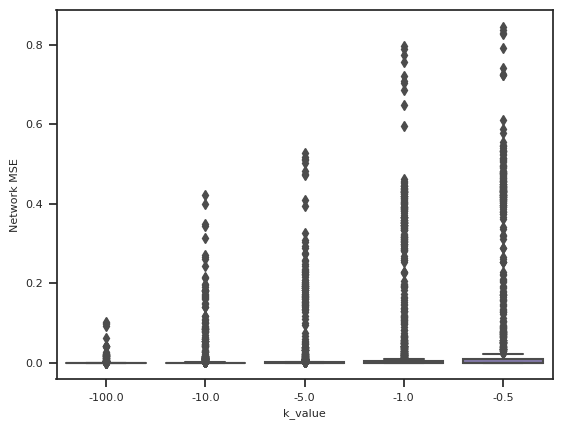

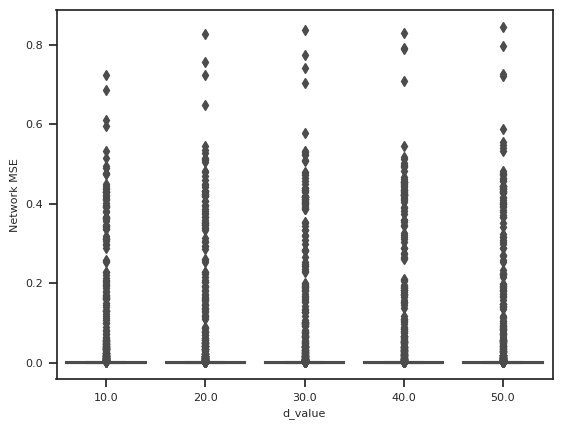

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


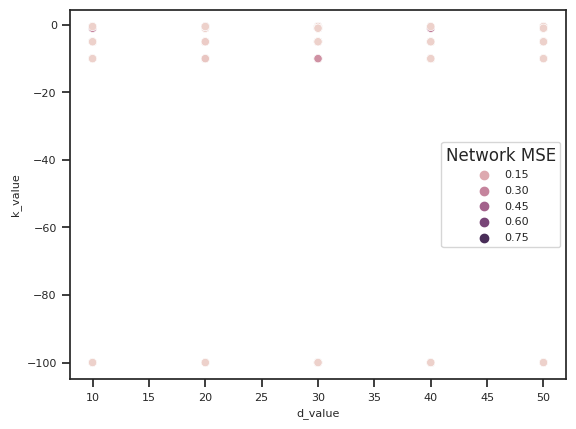

In [19]:
sns.boxplot(data=plt_perturb_mMSE[plt_perturb_mMSE["model"]=="student_division_same_input"], x="k_value", y='Network MSE')
plt.savefig("/dccstor/ipc1/CAR/BFN/Figures/Syntehtic_perturb_params_mMSE_k.pdf", bbox_inches="tight")
plt.show()

sns.boxplot(data=plt_perturb_mMSE[plt_perturb_mMSE["model"]=="student_division_same_input"], x="d_value", y='Network MSE')
plt.savefig("/dccstor/ipc1/CAR/BFN/Figures/Syntehtic_perturb_params_mMSE_d.pdf", bbox_inches="tight")
plt.show()

sns.scatterplot(data=plt_perturb_mMSE[plt_perturb_mMSE["model"]=="student_division_same_input"], x="d_value", hue='Network MSE', y="k_value")
plt.savefig("/dccstor/ipc1/CAR/BFN/Figures/Syntehtic_perturb_params_k_d.pdf", bbox_inches="tight")
plt.show()

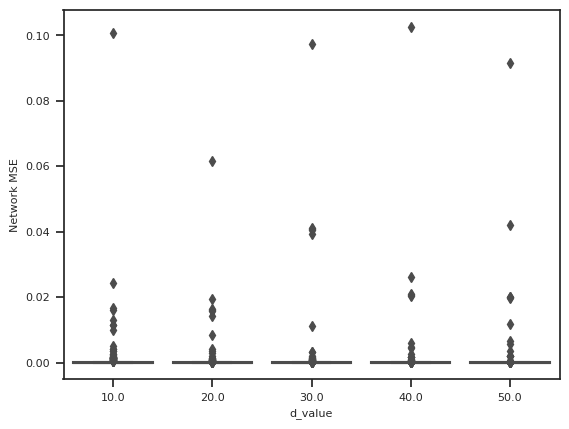

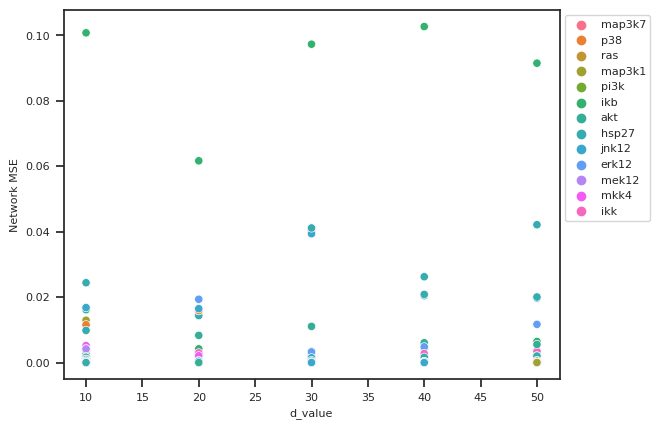

In [20]:
sns.boxplot(data=plt_perturb_mMSE[(plt_perturb_mMSE["model"]=="student_division_same_input")&
                                 (plt_perturb_mMSE["k_value"]==-100)], x="d_value", y='Network MSE')
plt.savefig("/dccstor/ipc1/CAR/BFN/Figures/Syntehtic_perturb_student_div_k-100_params_mMSE_d.pdf", bbox_inches="tight")
plt.show()

sns.scatterplot(data=plt_perturb_mMSE[(plt_perturb_mMSE["model"]=="student_division_same_input")&
                                 (plt_perturb_mMSE["k_value"]==-100)], x="d_value", y='Network MSE', hue="node")
plt.legend(bbox_to_anchor=(1,1))
plt.savefig("/dccstor/ipc1/CAR/BFN/Figures/Syntehtic_perturb_student_div_k-100_params_mMSE_d_node_color.pdf", bbox_inches="tight")
plt.show()


# Analyze selected result

In [21]:
d = 20
k = -100 

In [54]:
sel_perturb_MSE = perturb_MSE[(perturb_MSE["d_value"]==d)&
                           (perturb_MSE["k_value"]==k)]
sel_unperturb_MSE = unperturb_MSE[(unperturb_MSE["d_value"]==d)& 
                               (unperturb_MSE["k_value"]==k)]

sel_perturb_R2 = perturb_R2[(perturb_R2["d_value"]==d)& 
                        (perturb_R2["k_value"]==k)]
sel_unperturb_R2 = unperturb_R2[(unperturb_R2["d_value"]==d)& 
                            (unperturb_R2["k_value"]==k)]


sel_perturb_MSE   = sel_perturb_MSE.drop(["k_value", "d_value"], axis=1)
sel_unperturb_MSE = sel_unperturb_MSE.drop(["k_value", "d_value"], axis=1)
sel_perturb_R2    = sel_perturb_R2.drop(["k_value", "d_value"], axis=1)
sel_unperturb_R2  = sel_unperturb_R2.drop(["k_value", "d_value"], axis=1)


In [55]:
sel_perturb_R2

,setting,repeat,inhibited_node,model,mek12,erk12,mkk4,jnk12,ikk,ikb,ras,map3k7,pi3k,map3k1,akt,p38,hsp27
2975,85.0,0.0,mek12,student_division_random_input,-1.332247,-1.039160,-0.920203,-0.942379,-0.747758,-0.836575,-1.408332,-0.859244,-1.096611,-0.906279,-1.036776,-0.959886,-0.976264
2976,85.0,0.0,mek12,student_division_same_input,1.000000,-0.963035,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999982,1.000000,0.999992,1.000000,0.999997
2977,85.0,0.0,mek12,teacher_division_random_input,-1.050632,-0.894484,-1.026691,-1.017308,-1.087505,-1.070506,-1.058159,-1.035464,-1.068092,-1.036908,-1.004840,-1.017176,-1.019491
2978,85.0,0.0,mek12,teacher_division_same_input,1.000000,-0.963035,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999997
2979,85.0,0.0,mek12,teacher_k_inhibition_true,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5805,165.0,4.0,hsp27,teacher_division_random_input,-0.875382,-0.869548,-0.972769,-0.971964,-0.974341,-1.007273,-0.875247,-1.019187,-0.910384,-0.977358,-0.903638,-0.977491,-0.967781
5806,165.0,4.0,hsp27,teacher_division_same_input,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5807,165.0,4.0,hsp27,teacher_k_inhibition_true,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5808,165.0,4.0,hsp27,untrained_division_random_input,-1.187587,-1.242087,-0.872390,-0.912257,-0.711047,-0.781950,-1.037147,-0.892085,-0.790768,-0.973593,-0.601598,-0.940606,-0.935448


In [56]:
# sel_perturb_data = perturb_data[(perturb_data["d_value"]==d)&
#                         (perturb_data["k_value"]==k)]

# sel_unperturb_data = unperturb_data[(unperturb_data["d_value"]==d)&
#                         (unperturb_data["k_value"]==k)]


In [57]:
### TAKES LONG ###
# perturb_MMD = sel_data.groupby(["setting", "repeat", "k_value", "d_value", "inhibited_node"]).apply(compute_MMD, true_model_name="teacher_k_inhibition_true").reset_index().drop("level_5", axis=1).rename(columns={0: "MMD"})
# perturb_MMD.to_csv(f"{folder}results_perturbed_MMD.csv")
# unperturb_MMD = sel_unperturb_data.groupby(["setting", "repeat", "k_value", "d_value", "inhibited_node"]).apply(compute_MMD, true_model_name="teacher_no_pertrub_true").reset_index().drop("level_5", axis=1).rename(columns={0: "MMD"})
# unperturb_MMD.to_csv(f"{folder}results_unperturbed_MMD.csv")

# perturb_EMD = sel_data.groupby(["setting", "repeat", "k_value", "d_value", "inhibited_node"]).apply(compute_wasserstein, true_model_name="teacher_k_inhibition_true").reset_index().drop("level_5", axis=1).rename(columns={0: "EMD"})
# perturb_EMD.to_csv(f"{folder}results_perturbed_EMD.csv")
# unperturb_EMD = sel_unperturb_data.groupby(["setting", "repeat", "k_value", "d_value", "inhibited_node"]).apply(compute_wasserstein, true_model_name="teacher_no_pertrub_true").reset_index().drop("level_5", axis=1).rename(columns={0: "EMD"})
# unperturb_EMD.to_csv(f"{folder}results_unperturbed_EMD.csv")



In [58]:
sel_perturb_MMD   = pd.read_csv(f"{folder}results_perturbed_MMD.csv", index_col=0)
sel_unperturb_MMD = pd.read_csv(f"{folder}results_unperturbed_MMD.csv", index_col=0)
sel_perturb_EMD   = pd.read_csv(f"{folder}results_perturbed_EMD.csv", index_col=0)
sel_unperturb_EMD = pd.read_csv(f"{folder}results_unperturbed_EMD.csv", index_col=0)

In [59]:
sel_perturb_MMD

,setting,repeat,k_value,d_value,inhibited_node,model,MMD
0,85.0,0.0,-100.0,20.0,mek12,student_division_random_input,0.008255
1,85.0,0.0,-100.0,20.0,mek12,student_division_same_input,0.000205
2,85.0,0.0,-100.0,20.0,mek12,teacher_division_random_input,0.001395
3,85.0,0.0,-100.0,20.0,mek12,teacher_division_same_input,0.000205
4,85.0,0.0,-100.0,20.0,mek12,teacher_k_inhibition_true,0.000000
...,...,...,...,...,...,...,...
590,165.0,4.0,-100.0,20.0,hsp27,teacher_division_random_input,0.000567
591,165.0,4.0,-100.0,20.0,hsp27,teacher_division_same_input,0.000000
592,165.0,4.0,-100.0,20.0,hsp27,teacher_k_inhibition_true,0.000000
593,165.0,4.0,-100.0,20.0,hsp27,untrained_division_random_input,0.011784


In [60]:
sel_perturb_MMD   = sel_perturb_MMD.drop(["k_value", "d_value"], axis=1)
sel_unperturb_MMD = sel_unperturb_MMD.drop(["k_value", "d_value"], axis=1)
sel_perturb_EMD   = sel_perturb_EMD.drop(["k_value", "d_value"], axis=1)
sel_unperturb_EMD = sel_unperturb_EMD.drop(["k_value", "d_value"], axis=1)

# R2, so same inputs

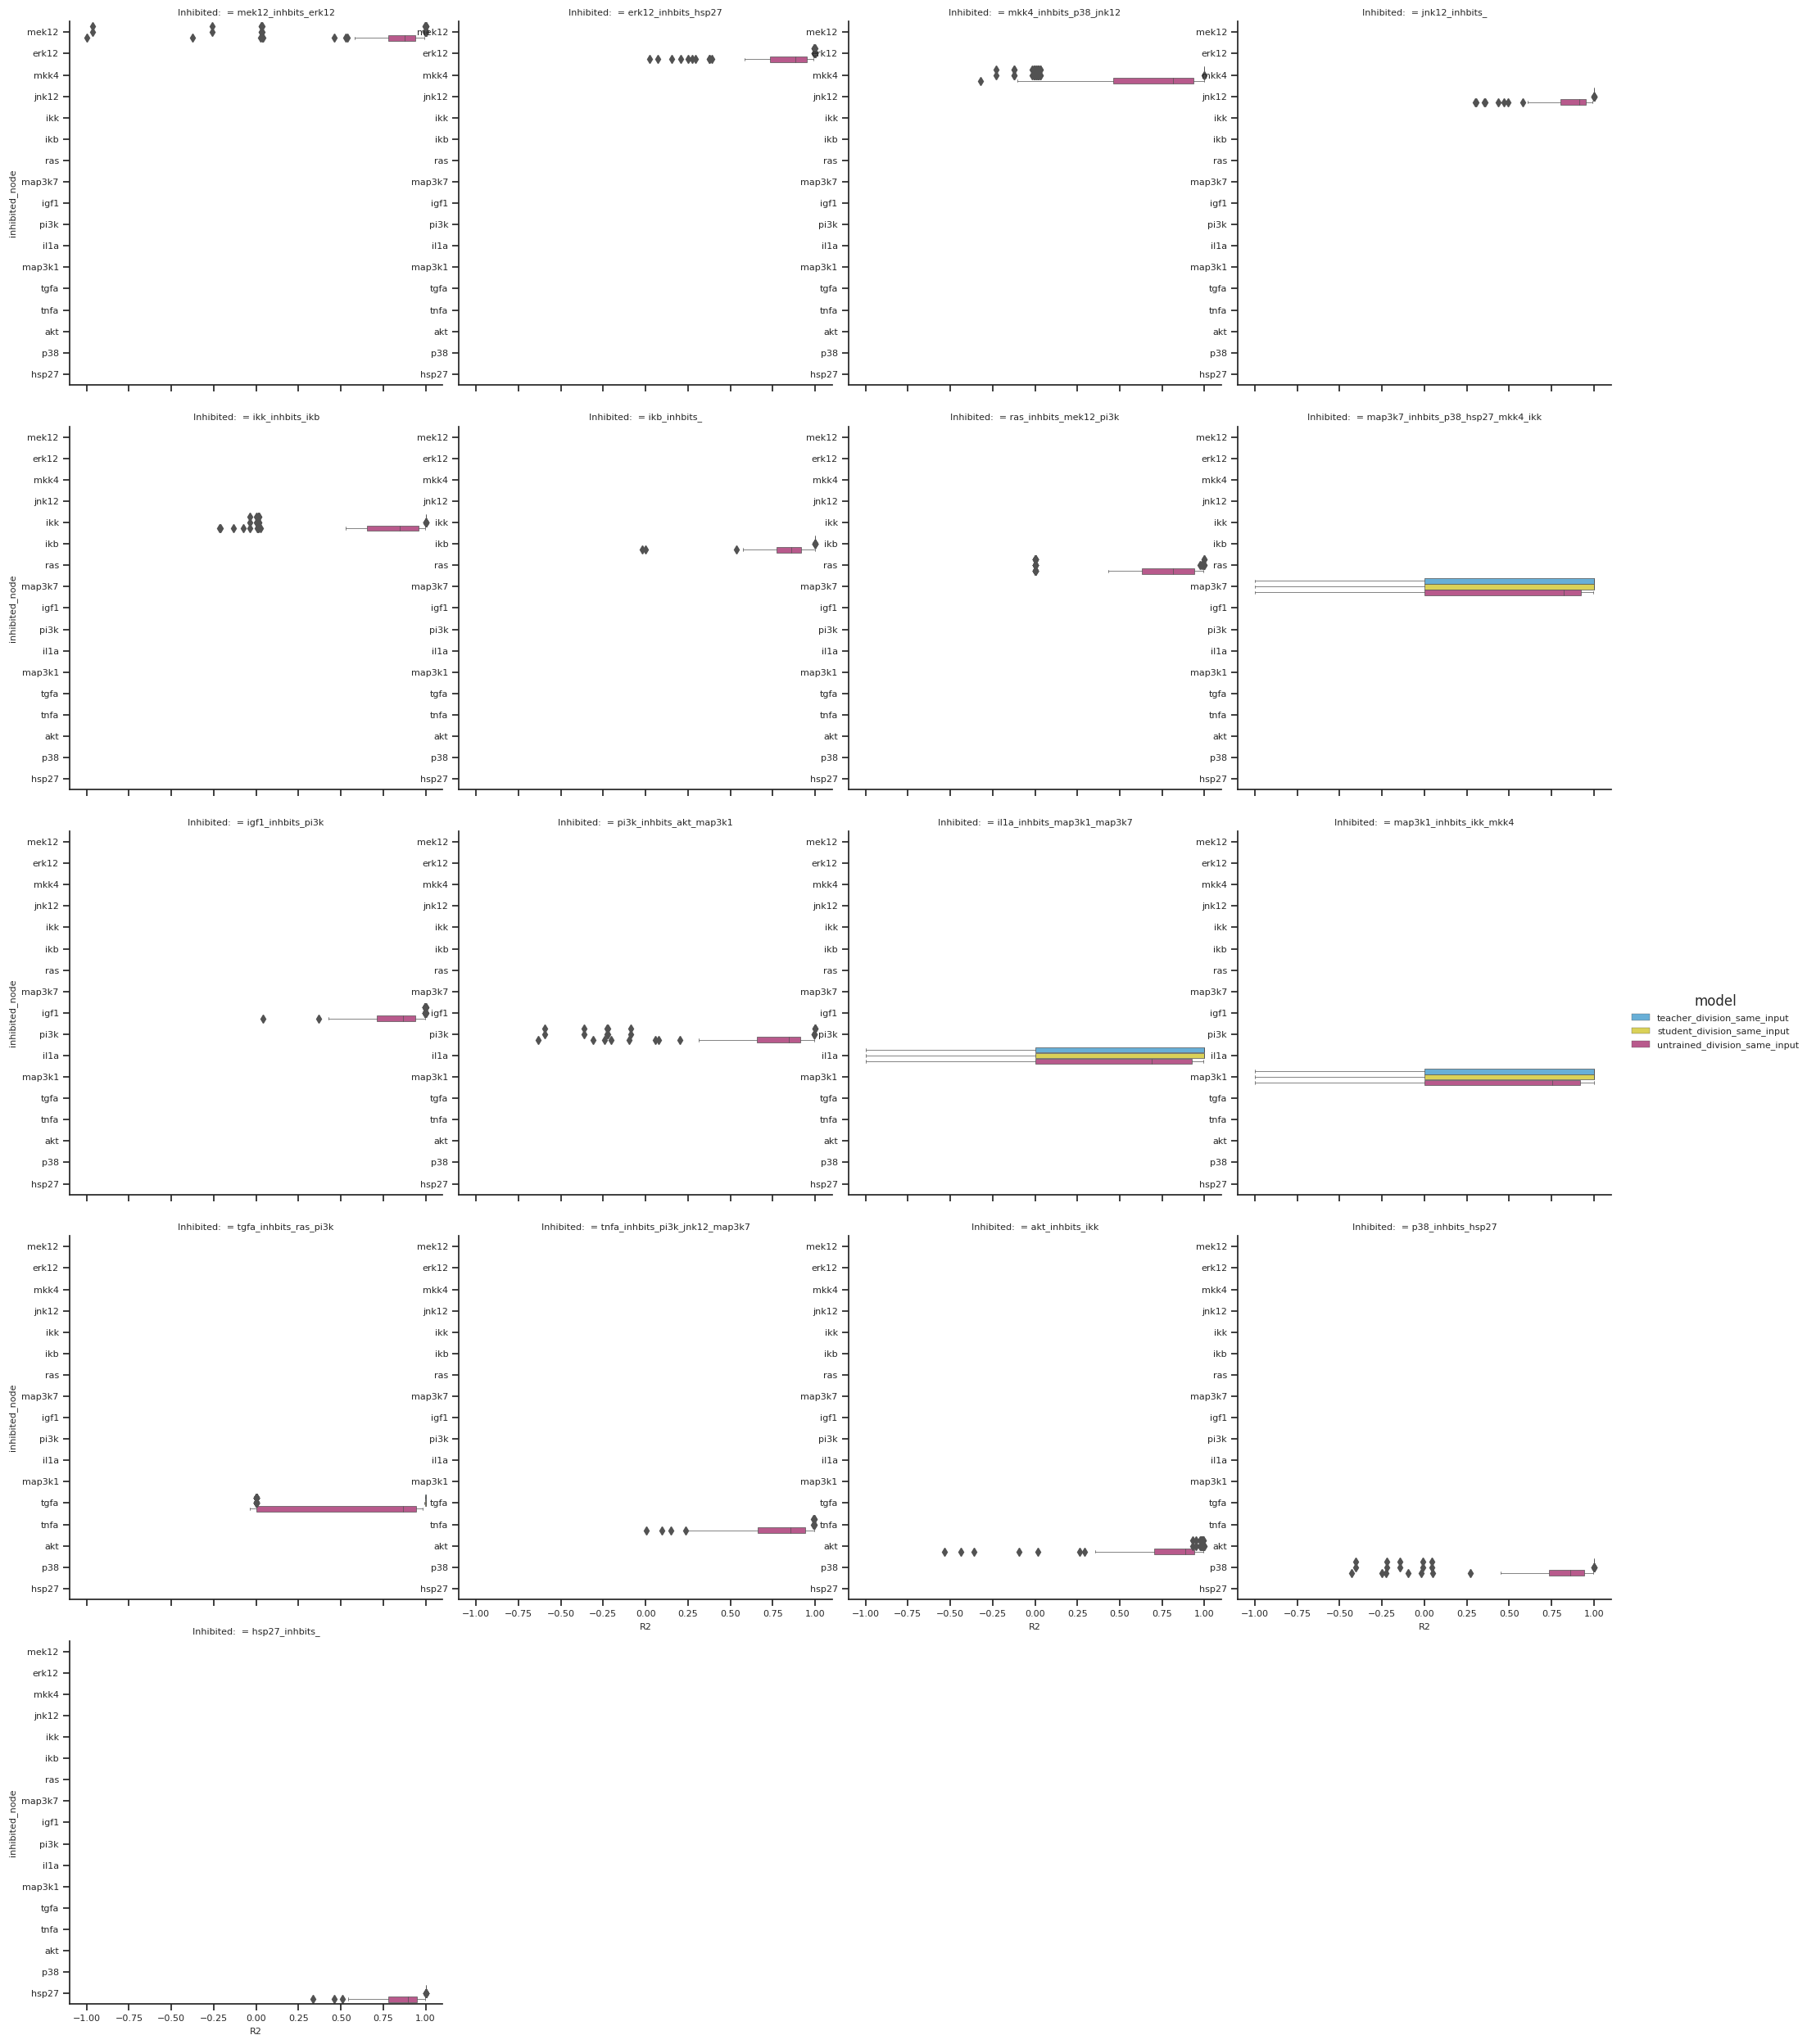

In [63]:
plt_data = sel_perturb_R2[["same" in m for m in sel_perturb_R2["model"]]]
plt_data = plt_data.melt(id_vars=["setting", "repeat", "model", "inhibited_node"], var_name="node", value_name="R2")
plt_data["Inhibited: "] = plt_data["inhibited_node"].map(child_dict)
temp = plt_data.copy()
temp.loc[temp["R2"]<-1, "R2"] = -1
g = sns.catplot(data=temp, y="inhibited_node", x="R2", col="Inhibited: ", 
                col_wrap=4, kind="box", hue="model", palette=perturbation_models_dict,
               linewidth=0.5, hue_order = ['teacher_division_same_input', 
                                           'student_division_same_input', 
                                           'untrained_division_same_input'])
for ax in g.axes.flatten():
    ax.tick_params(labelleft=True)
    
plt.savefig("/dccstor/ipc1/CAR/BFN/Figures/Syntehtic_perturb_R2_same_inputs.pdf", bbox_inches="tight")
plt.show()

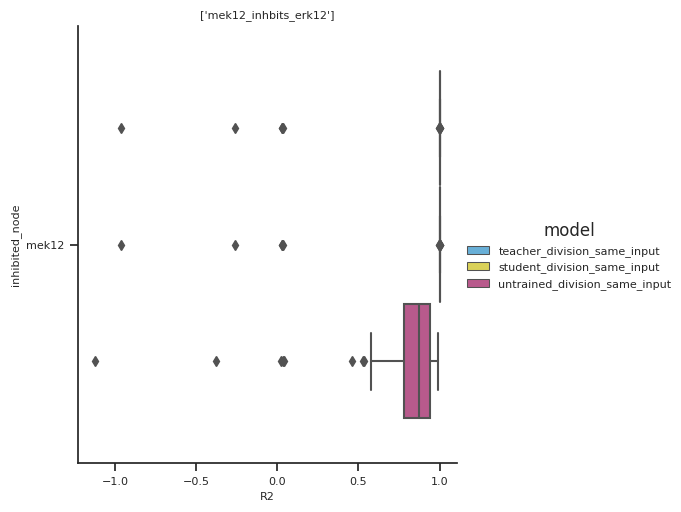

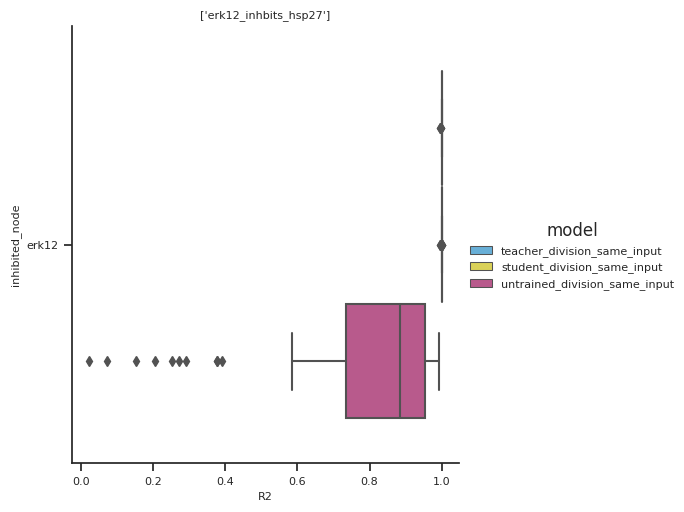

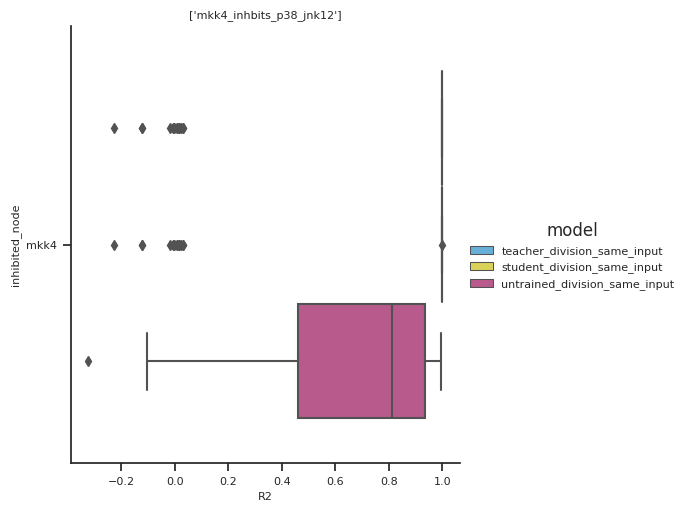

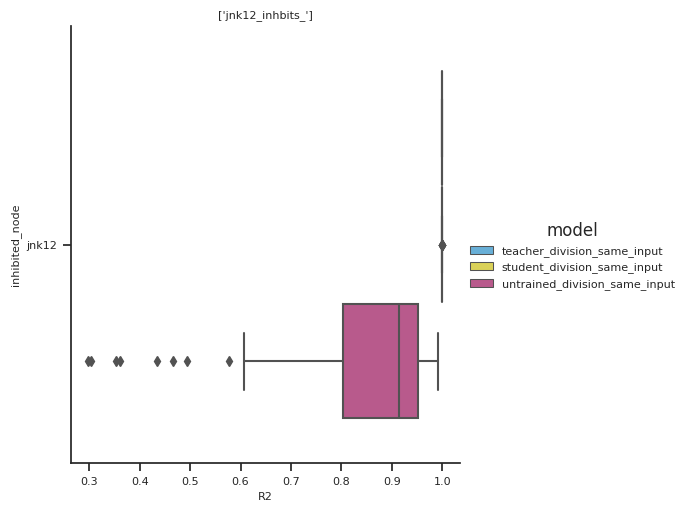

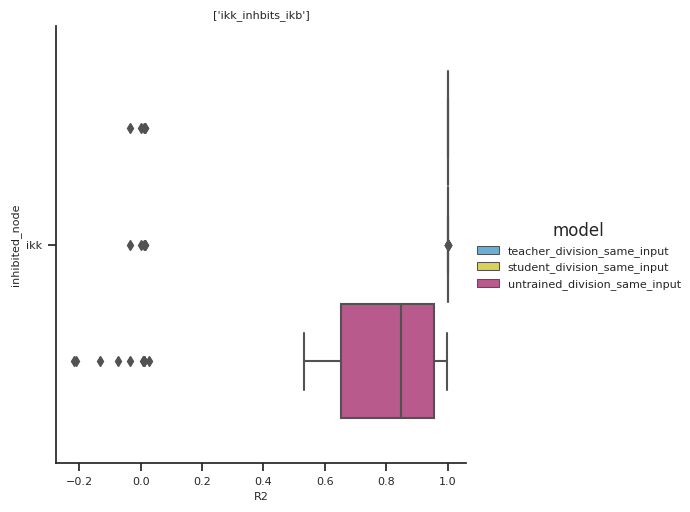

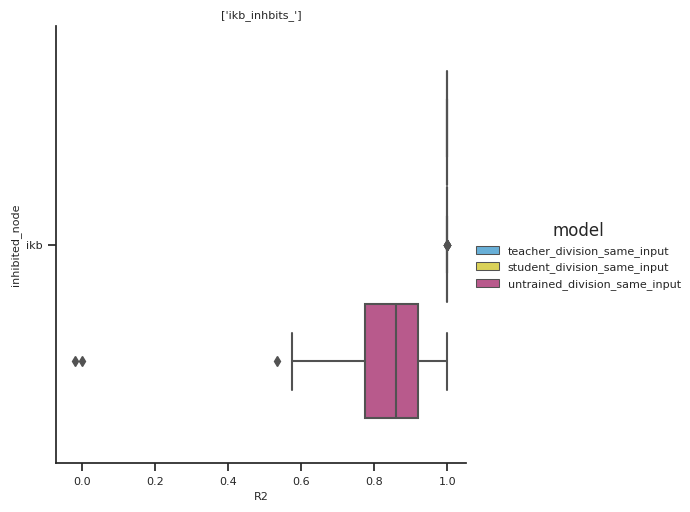

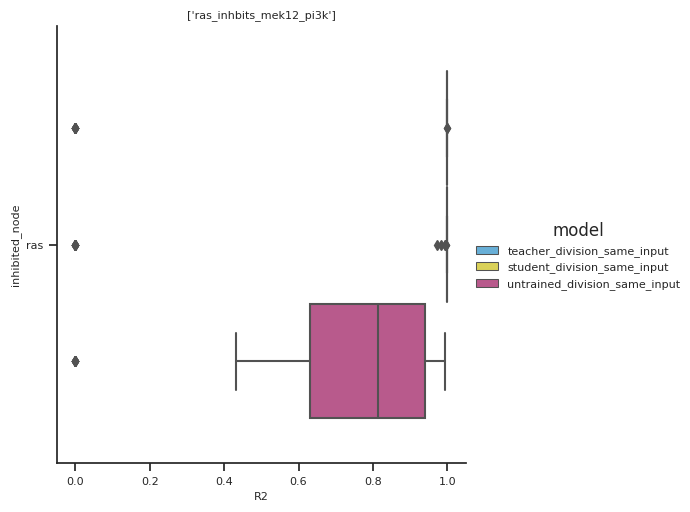

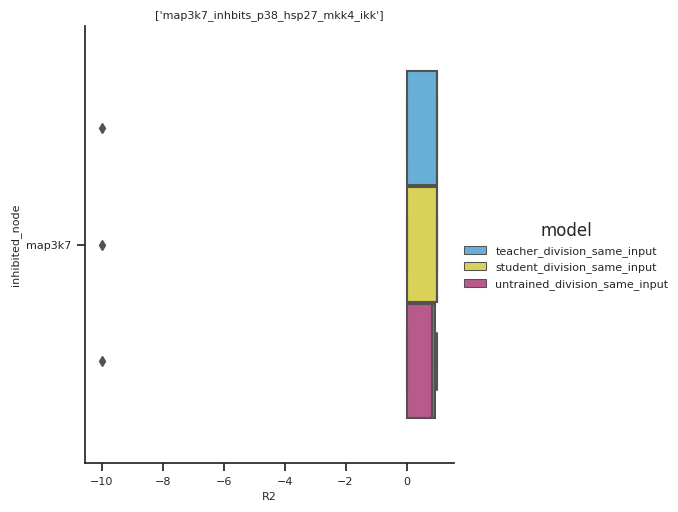

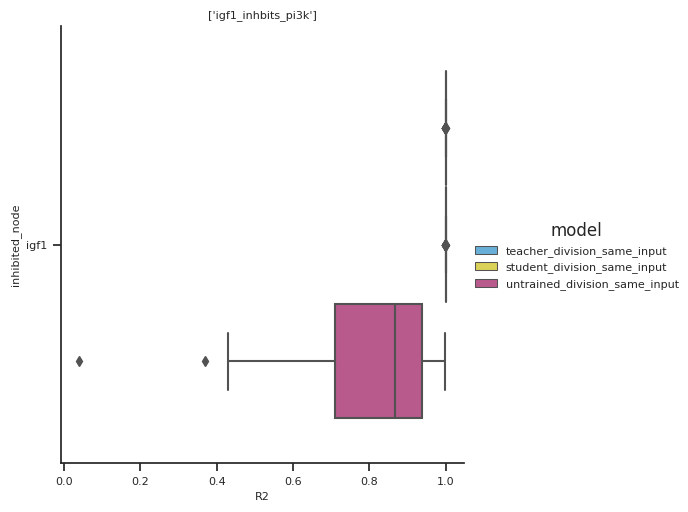

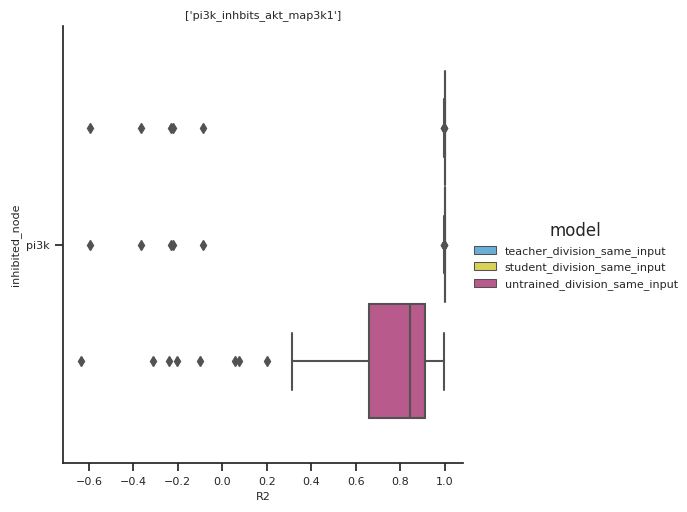

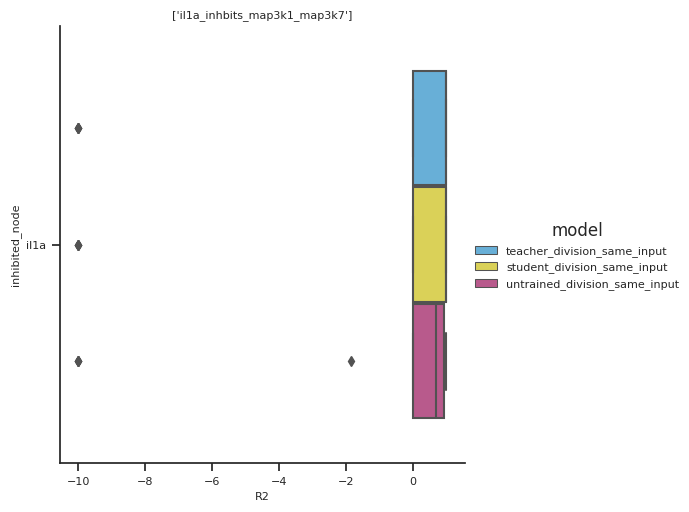

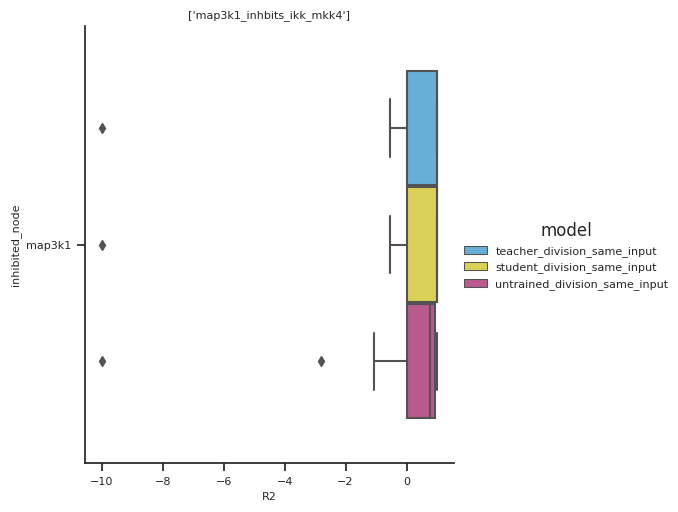

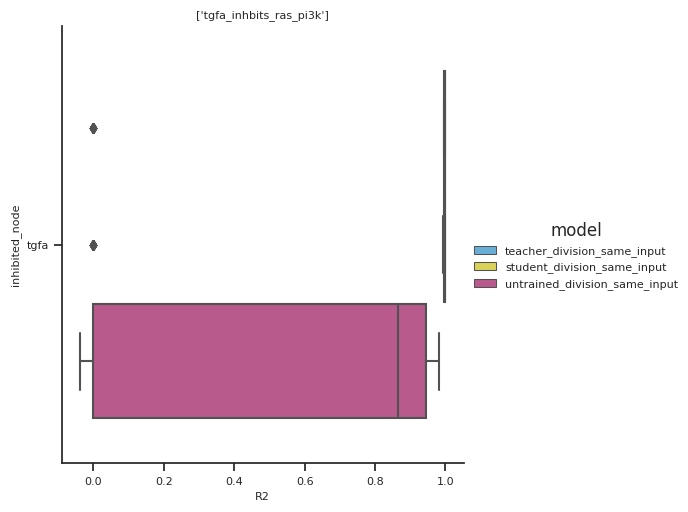

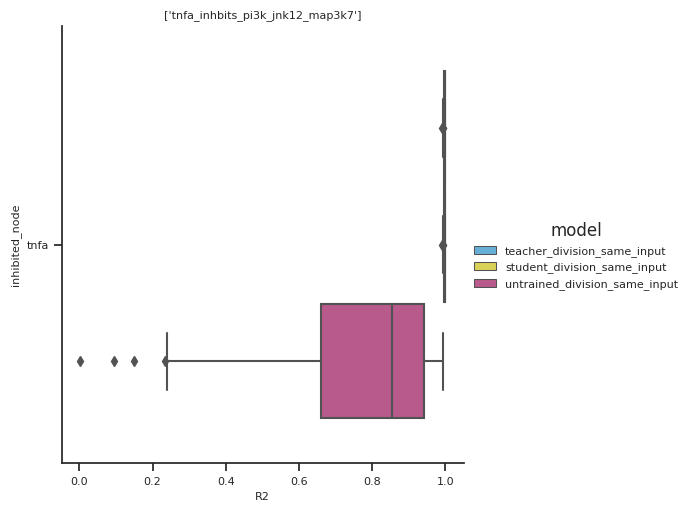

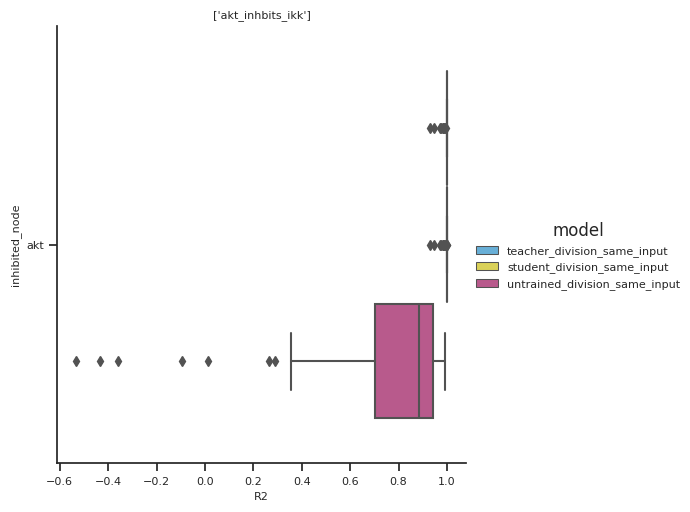

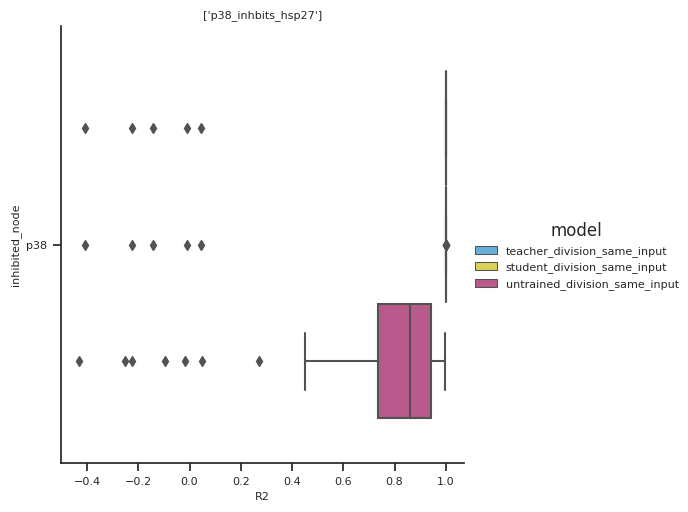

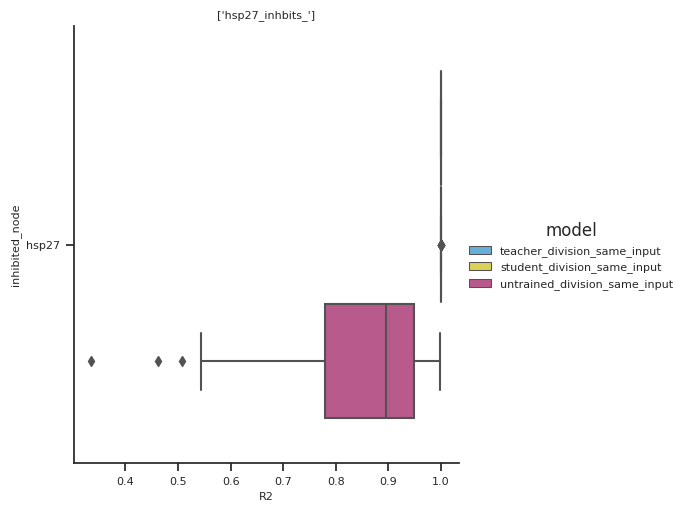

In [65]:
for n in plt_data["inhibited_node"].unique():
    temp = plt_data[plt_data["inhibited_node"]==n]
    temp.loc[temp["R2"]<-10, "R2"] = -10
    sns.catplot(data=temp, y="inhibited_node", x="R2", kind="box", hue="model", palette=perturbation_models_dict, 
              hue_order = ['teacher_division_same_input', 'student_division_same_input', 'untrained_division_same_input'])
    plt.title(temp["Inhibited: "].unique())
    plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Syntehtic_perturb_R2_same_inputs_{n}_inhibited.pdf", bbox_inches="tight")
    plt.show()

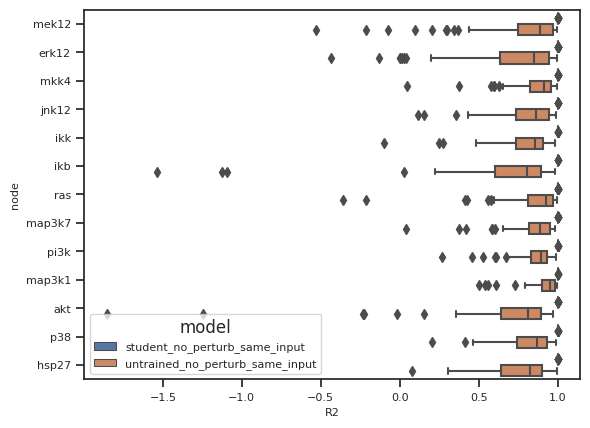

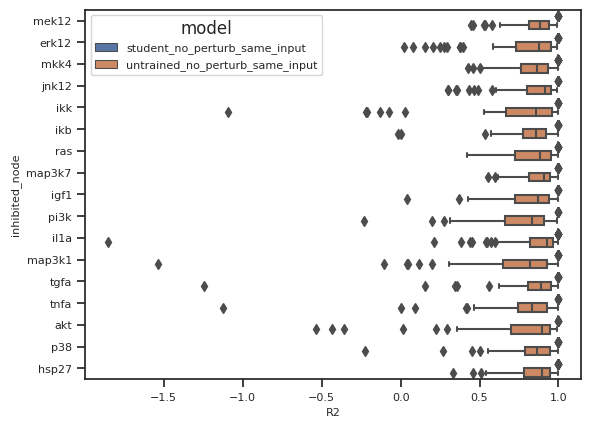

In [66]:
# In unperturbed data, there is no inhibition so all settings are the same (inhibited node doesn't matter)
plt_data = sel_unperturb_R2[["same" in m for m in sel_unperturb_R2["model"]]]
plt_data = plt_data.melt(id_vars=["setting", "repeat", "model", "inhibited_node"], var_name="node", value_name="R2")
sns.boxplot(data = plt_data, y="node", x="R2", hue="model")
plt.show()

sns.boxplot(data = plt_data, y="inhibited_node", x="R2", hue="model")
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Syntehtic_perturb_R2_same_inputs_no_perturbation.pdf", bbox_inches="tight")
plt.show()


# MMD div, so unmatched inputs

/tmp/ipykernel_3473703/2446321051.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plt_data["Inhibited: "] = plt_data["inhibited_node"].map(child_dict)


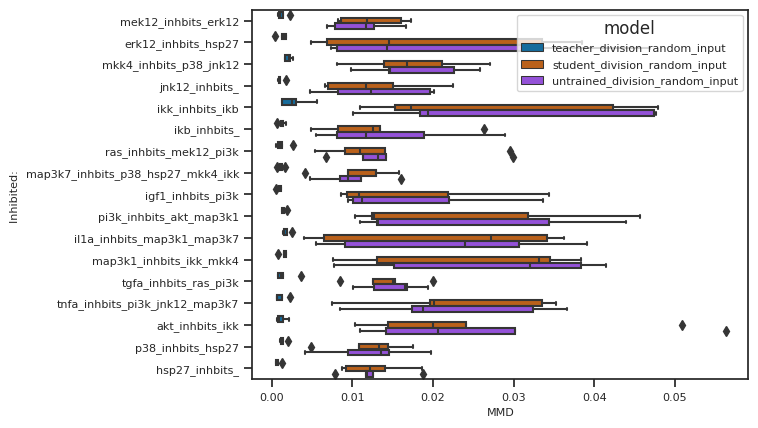

In [67]:
plt_data = sel_perturb_MMD[["random" in m for m in sel_perturb_MMD["model"]]]
plt_data["Inhibited: "] = plt_data["inhibited_node"].map(child_dict)
sns.boxplot(data=plt_data, y="Inhibited: ", x="MMD", hue="model", palette=perturbation_models_dict, 
            hue_order=["teacher_division_random_input", "student_division_random_input", "untrained_division_random_input"])
    
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Syntehtic_perturb_MMD_random_inputs.pdf", bbox_inches="tight")
plt.show()

## MMD on matched inputs

/tmp/ipykernel_3473703/1480134990.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plt_data["Inhibited: "] = plt_data["inhibited_node"].map(child_dict)


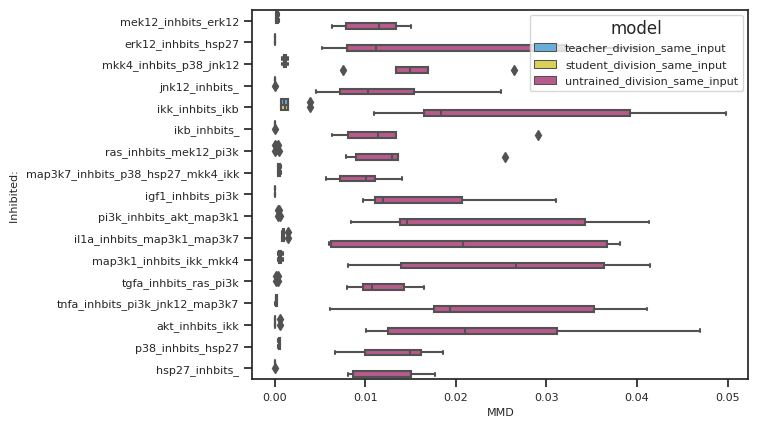

In [68]:
plt_data = sel_perturb_MMD[["same" in m for m in sel_perturb_MMD["model"]]]
plt_data["Inhibited: "] = plt_data["inhibited_node"].map(child_dict)

sns.boxplot(data=plt_data, y="Inhibited: ", x="MMD", hue="model", palette=perturbation_models_dict, 
            hue_order=["teacher_division_same_input", "student_division_same_input", "untrained_division_same_input"])

plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Syntehtic_perturb_MMD_same_inputs.pdf", bbox_inches="tight")
plt.show()

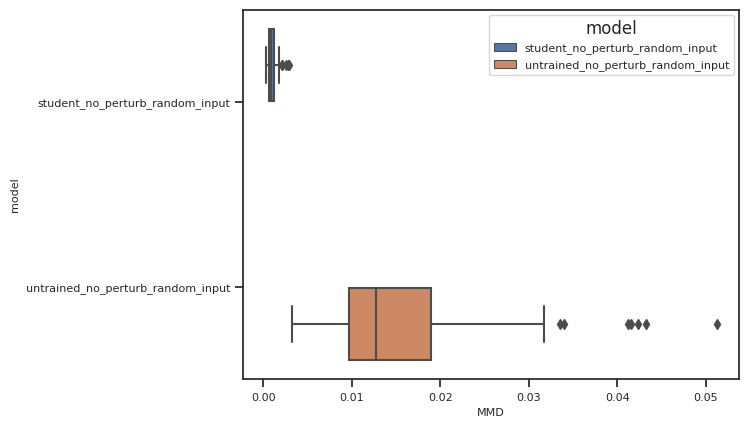

In [69]:
# In unperturbed data, there is no inhibition so all settings are the same (inhibited node doesn't matter)
plt_data = sel_unperturb_MMD[["random" in m for m in sel_unperturb_MMD["model"]]]
sns.boxplot(data=plt_data, y="model", x="MMD", hue="model")
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Syntehtic_perturb_MMD_random_inputs_no_perturb.pdf", bbox_inches="tight")
plt.show()

# EMD, unmatched input

/tmp/ipykernel_3473703/1844864046.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plt_data["Inhibited: "] = plt_data["inhibited_node"].map(child_dict)


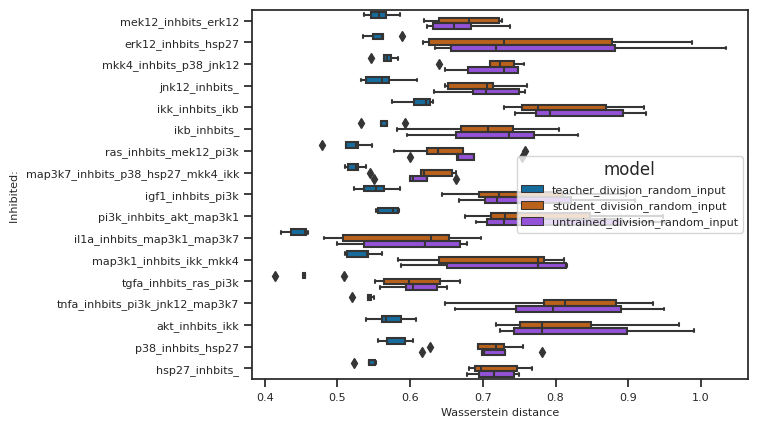

In [70]:
plt_data = sel_perturb_EMD[["random" in m for m in sel_perturb_EMD["model"]]]
plt_data["Inhibited: "] = plt_data["inhibited_node"].map(child_dict)
sns.boxplot(data=plt_data, y="Inhibited: ", x="EMD", hue="model", palette=perturbation_models_dict, 
            hue_order=["teacher_division_random_input", "student_division_random_input", "untrained_division_random_input"])
t = plt.xlabel("Wasserstein distance")
    
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Syntehtic_perturb_EMD_random_inputs.pdf", bbox_inches="tight")
plt.show()

## EMD same inputs

/tmp/ipykernel_3473703/3218665613.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plt_data["Inhibited: "] = plt_data["inhibited_node"].map(child_dict)


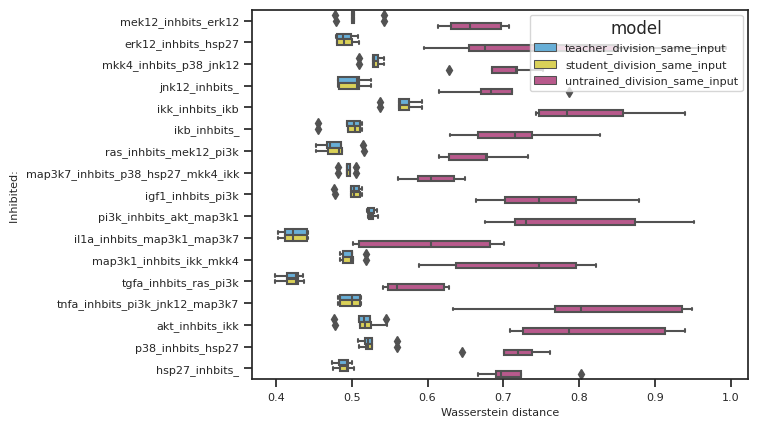

In [71]:
plt_data = sel_perturb_EMD[["same" in m for m in sel_perturb_EMD["model"]]]
plt_data["Inhibited: "] = plt_data["inhibited_node"].map(child_dict)

sns.boxplot(data=plt_data, y="Inhibited: ", x="EMD", hue="model", palette=perturbation_models_dict, 
            hue_order=["teacher_division_same_input", "student_division_same_input", "untrained_division_same_input"])
t = plt.xlabel("Wasserstein distance")

plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Syntehtic_perturb_EMD_same_inputs.pdf", bbox_inches="tight")
plt.show()

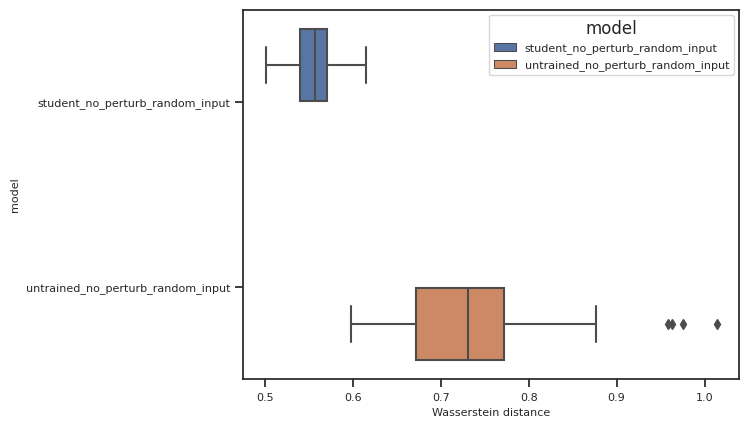

In [72]:
# In unperturbed data, there is no inhibition so all settings are the same (inhibited node doesn't matter)
plt_data = sel_unperturb_EMD[["random" in m for m in sel_unperturb_EMD["model"]]]
sns.boxplot(data=plt_data, y="model", x="EMD", hue="model")
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Syntehtic_perturb_EMD_random_inputs_no_perturb.pdf", bbox_inches="tight")
t = plt.xlabel("Wasserstein distance")

plt.show()

# MSE, so matched input

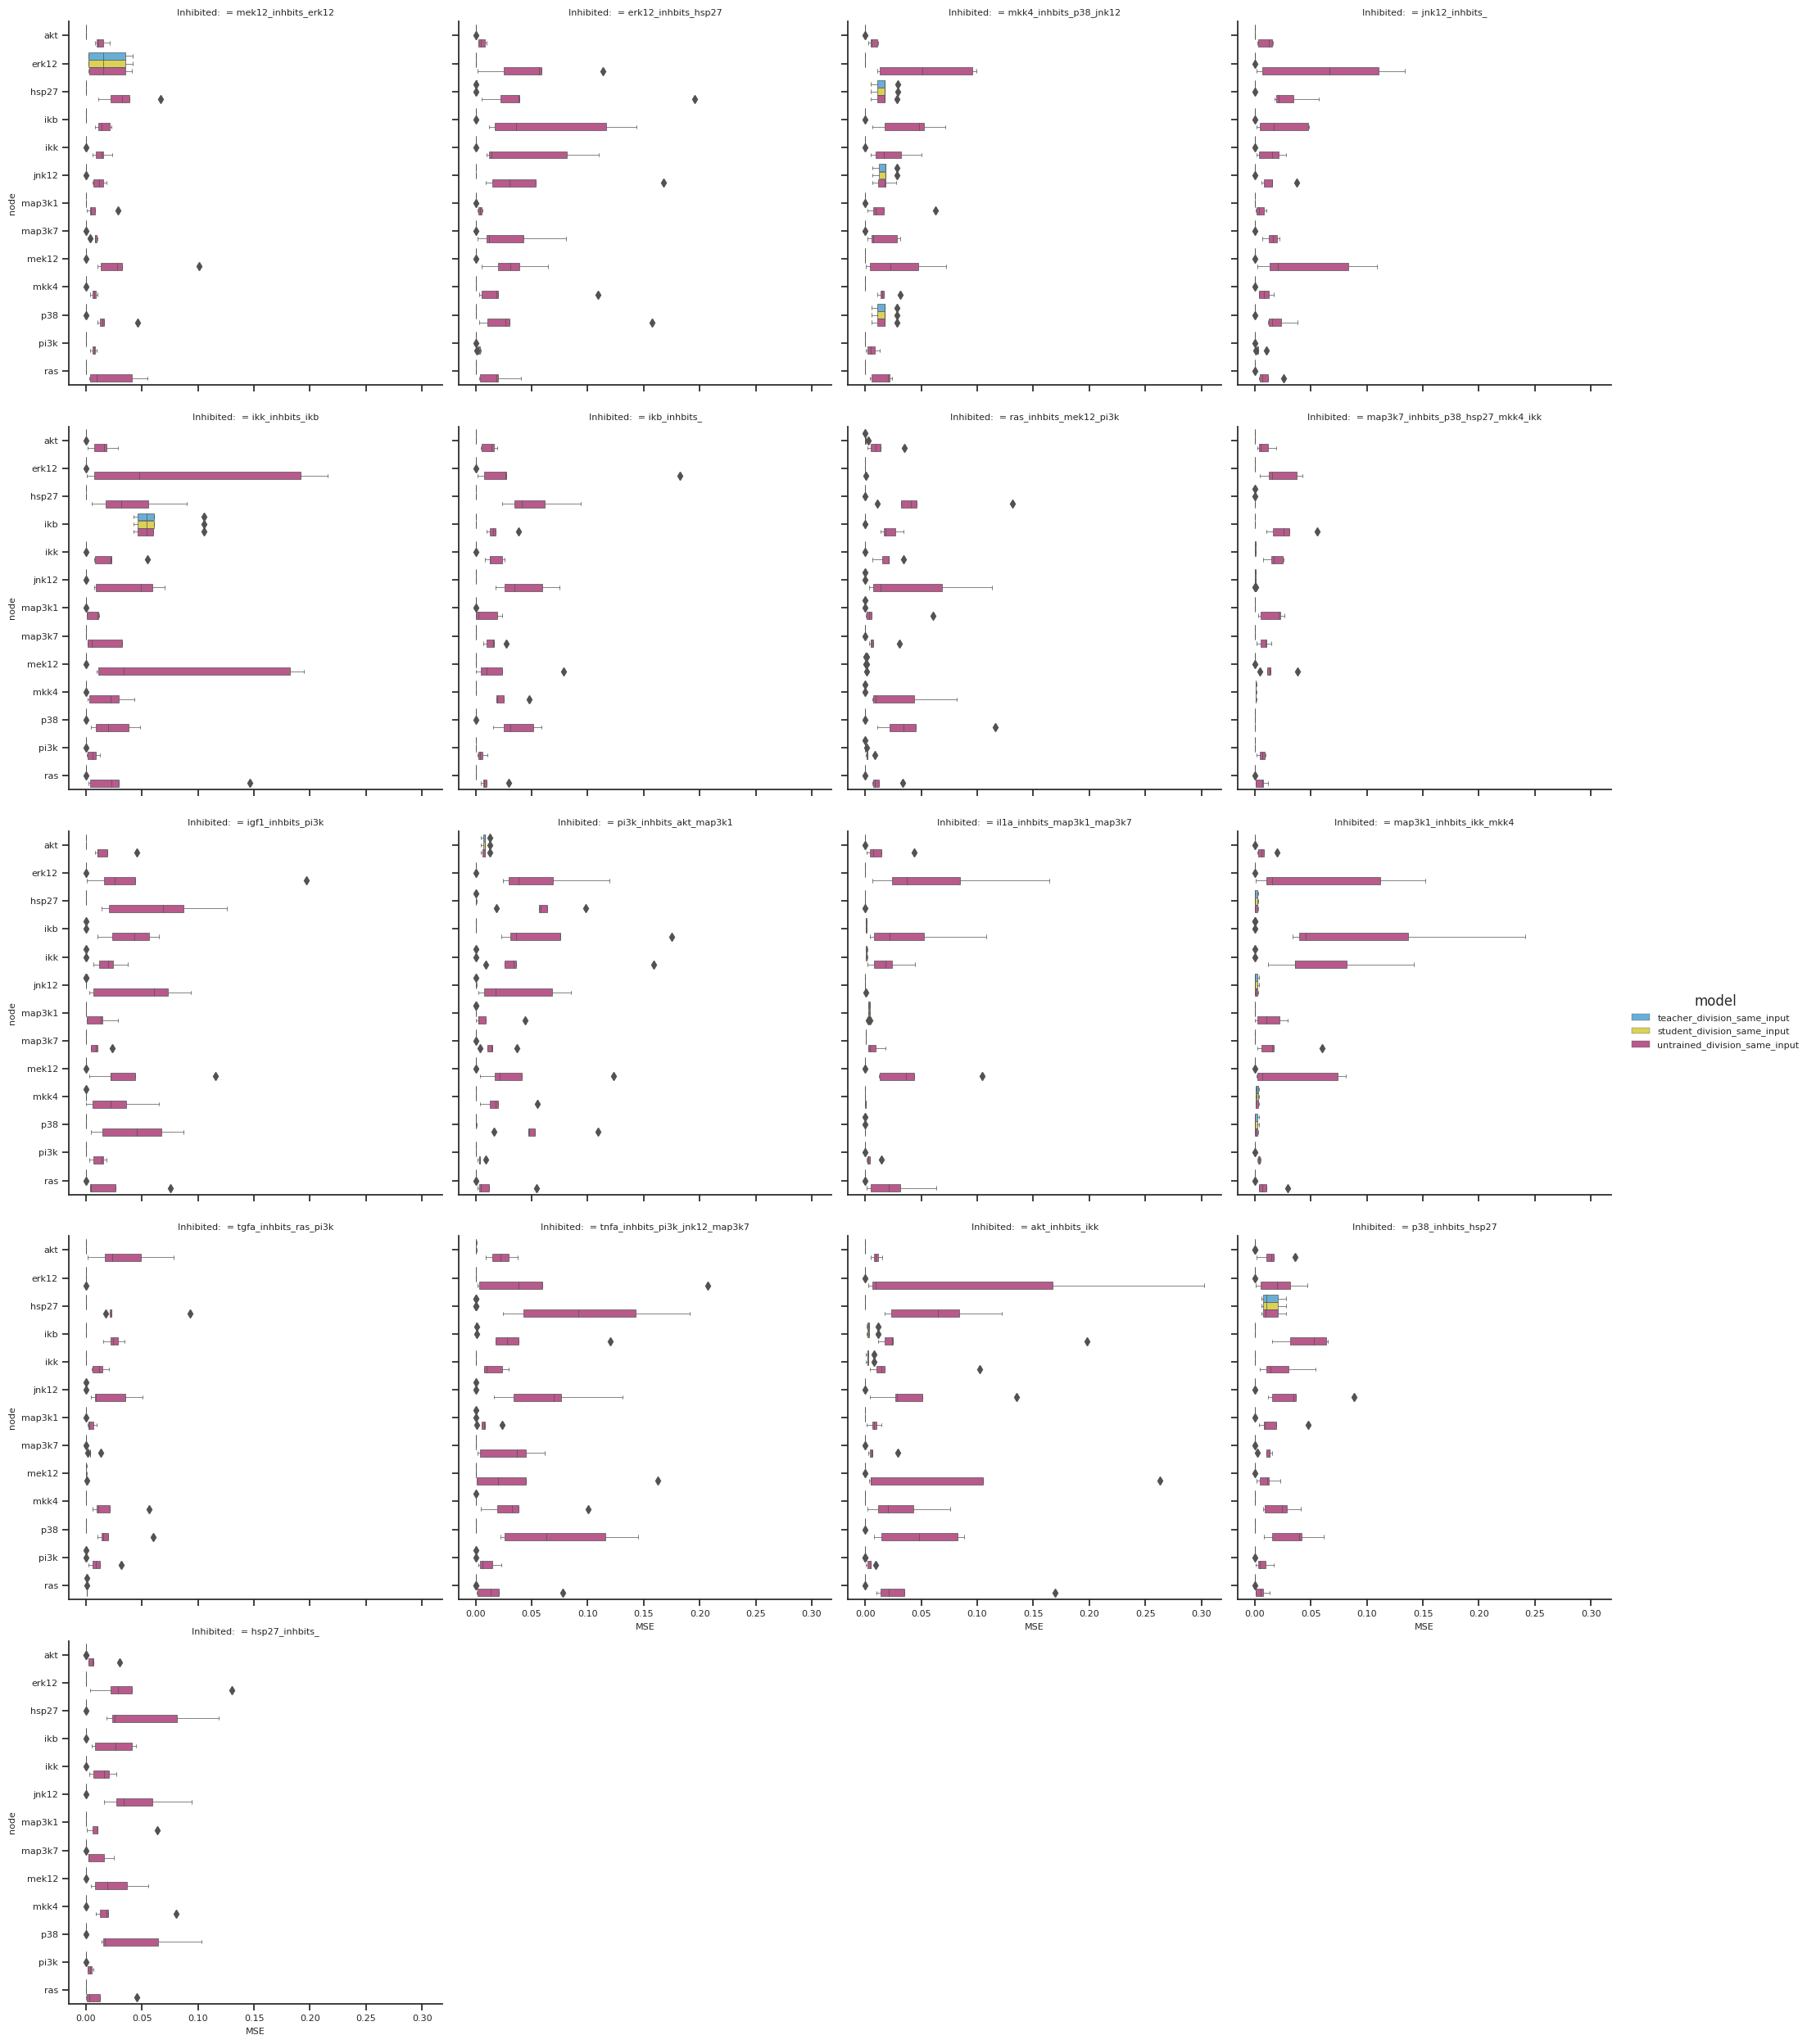

In [73]:
plt_data = sel_perturb_MSE[["same" in m for m in sel_perturb_MSE["model"]]]
plt_data = plt_data.melt(id_vars=["setting", "repeat", "model", "inhibited_node"], var_name="node", value_name="MSE")
plt_data["Inhibited: "] = plt_data["inhibited_node"].map(child_dict)
g = sns.catplot(data=plt_data, y="node", x="MSE", col="Inhibited: ", 
                col_wrap=4, kind="box", hue="model", palette=perturbation_models_dict,
               linewidth=0.5, hue_order=["teacher_division_same_input", "student_division_same_input", "untrained_division_same_input"])
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Syntehtic_perturb_MSE_same_inputs.pdf", bbox_inches="tight")
plt.show()

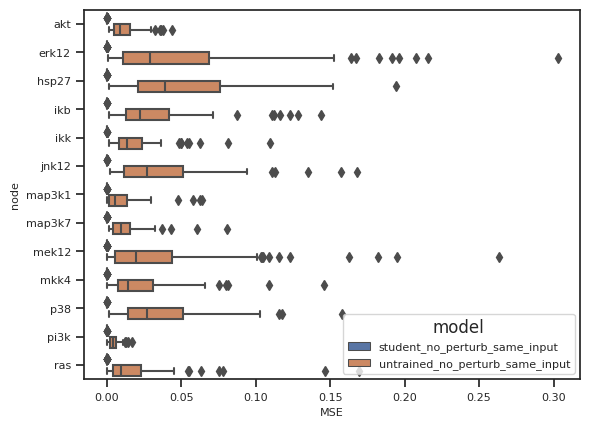

In [74]:
# In unperturbed data, there is no inhibition so all settings are the same (inhibited node doesn't matter)
plt_data = sel_unperturb_MSE[["same" in m for m in sel_unperturb_MSE["model"]]]
plt_data = plt_data.melt(id_vars=["setting", "repeat", "model", "inhibited_node"], var_name="node", value_name="MSE")
sns.boxplot(data=plt_data, y="node", x="MSE", hue="model")
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Syntehtic_perturb_MSE_same_inputs_no_perturb.pdf", bbox_inches="tight")
plt.show()

In [75]:
perturb_MSE["model"].unique()

array(['student_division_random_input', 'student_division_same_input',
       'teacher_division_random_input', 'teacher_division_same_input',
       'teacher_k_inhibition_true', 'untrained_division_random_input',
       'untrained_division_same_input'], dtype=object)

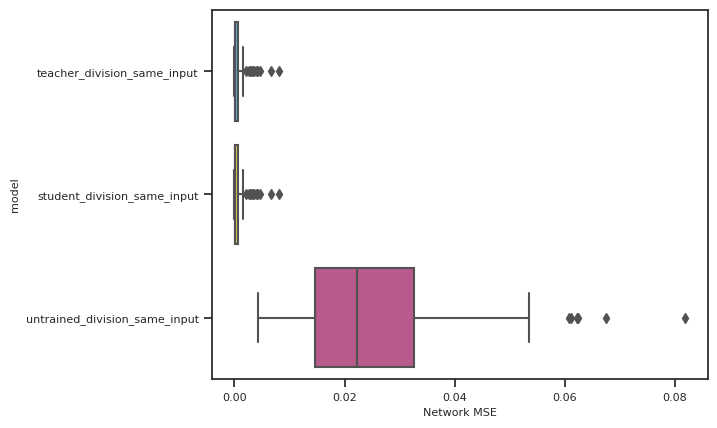

In [83]:
plt_data = sel_perturb_MSE.melt(id_vars=["setting", "repeat", "inhibited_node", "model"], 
                            var_name="predicted_node", value_name="MSE")
plt_data = plt_data.groupby(["setting", 
                             "repeat", 
                             "inhibited_node", 
                             "model"]).mean(numeric_only=True).reset_index()
plt_data= plt_data[plt_data["model"].isin(['student_division_same_input', 
                                           'untrained_division_same_input', 
                                           'teacher_division_same_input'])]
sns.boxplot(data=plt_data, y="model", x="MSE", palette=perturbation_models_dict, order = ['teacher_division_same_input', 
                                           'student_division_same_input', 
                                           'untrained_division_same_input'])
t = plt.xlabel("Network MSE")
plt.savefig("/dccstor/ipc1/CAR/BFN/Figures/Syntehtic_perturb_network_MSE.pdf",
           bbox_inches="tight")

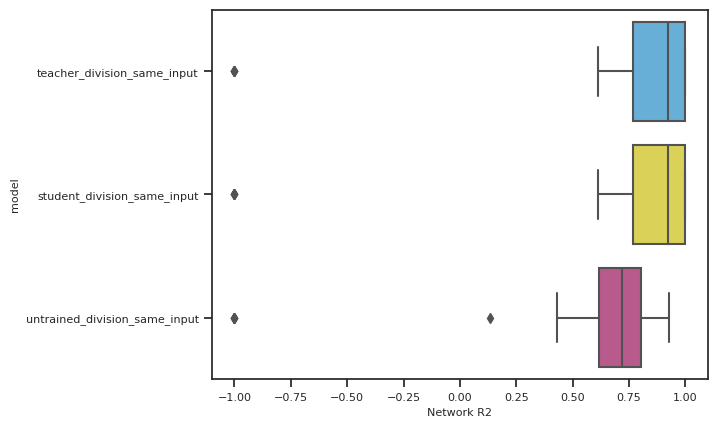

In [82]:
plt_data = sel_perturb_R2.melt(id_vars=["setting", "repeat", "inhibited_node", "model"], 
                            var_name="predicted_node", value_name="R2")
plt_data = plt_data.groupby(["setting", 
                             "repeat", 
                             "inhibited_node", 
                             "model"]).mean(numeric_only=True).reset_index()
plt_data= plt_data[plt_data["model"].isin(['student_division_same_input', 
                                           'untrained_division_same_input', 
                                           'teacher_division_same_input'])]
plt_data.loc[plt_data["R2"]<-1, "R2"] = -1

sns.boxplot(data=plt_data, y="model", x="R2", palette=perturbation_models_dict, order = ['teacher_division_same_input', 
                                           'student_division_same_input', 
                                           'untrained_division_same_input'])
t = plt.xlabel("Network R2")
plt.savefig("/dccstor/ipc1/CAR/BFN/Figures/Syntehtic_perturb_network_R2.pdf",
           bbox_inches="tight")

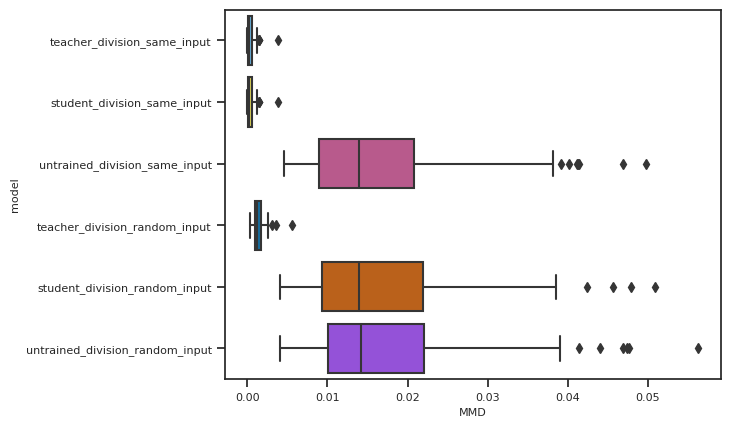

In [81]:
plt_data= sel_perturb_MMD[sel_perturb_MMD["model"].isin(['student_division_same_input', 
                                           'untrained_division_same_input', 
                                           'teacher_division_same_input',
                                           'student_division_random_input', 
                                           'untrained_division_random_input', 
                                           'teacher_division_random_input'])]

sns.boxplot(data=plt_data, y="model", x="MMD", palette=perturbation_models_dict, order=['teacher_division_same_input', 
                                           'student_division_same_input', 
                                           'untrained_division_same_input',
                                           'teacher_division_random_input', 
                                           'student_division_random_input', 
                                           'untrained_division_random_input'])
plt.savefig("/dccstor/ipc1/CAR/BFN/Figures/Syntehtic_perturb_MMD_same_and_random_inputs.pdf",
           bbox_inches="tight")

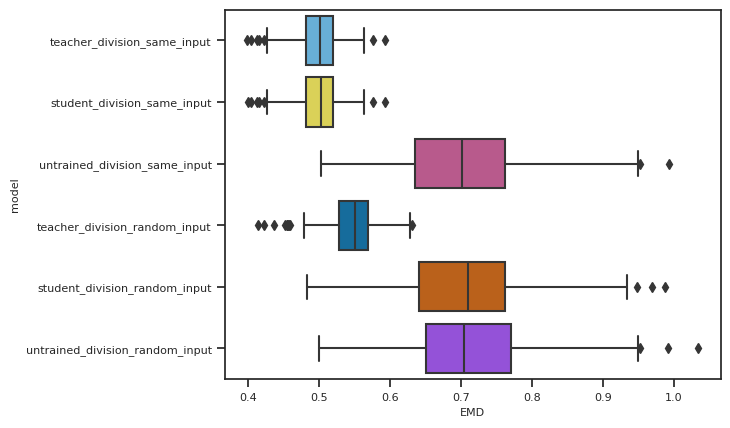

In [80]:
plt_data= sel_perturb_EMD[sel_perturb_EMD["model"].isin(['teacher_division_same_input', 
                                           'student_division_same_input', 
                                           'untrained_division_same_input',
                                           'teacher_division_random_input', 
                                           'student_division_random_input', 
                                           'untrained_division_random_input'])]
t=plt.xlabel("Wasserstein distance")
sns.boxplot(data=plt_data, y="model", x="EMD", palette=perturbation_models_dict, order=['teacher_division_same_input', 
                                           'student_division_same_input', 
                                           'untrained_division_same_input',
                                           'teacher_division_random_input', 
                                           'student_division_random_input', 
                                           'untrained_division_random_input'])
plt.savefig("/dccstor/ipc1/CAR/BFN/Figures/Syntehtic_perturb_EMD_same_and_random_inputs.pdf",
           bbox_inches="tight")